In [1]:
import re
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic') ## 리눅스로 서버 구동 시 'NanumGothic'으로 변경

# 데이터 csv로 변경(4.2 완료)

In [2]:
# 파일 읽어오기(readlines)
def read_kko_msg(filename):
    with open(filename, encoding='utf-8') as f:
        msg_list = f.readlines()
    return msg_list

In [3]:
# 앱_안드로이드 형식 txt 파일 처리
def apply_kko_regex_app_android(msg_list):
    kko_pattern = re.compile("([^\n]+) (오전|오후) ([0-9:\s]+), ([^\n,^\:]+) : ([^\n]+)")
    emoji_pattern = re.compile("["u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)

    kko_parse_result = list()
    cur_date = ""

    for msg in msg_list:
        kko_pattern_result = kko_pattern.findall(msg)
        if len(kko_pattern_result) > 0:
            tokens = list(kko_pattern_result[0])
            cur_date = dt.datetime.strptime(tokens[0], "%Y년 %m월 %d일")
            cur_date = cur_date.strftime("%Y-%m-%d")
            tokens.insert(0, cur_date)
            # 이모지 데이터 삭제
            tokens[-1] = re.sub(emoji_pattern, "", tokens[-1])
            kko_parse_result.append(tokens)
                

    kko_parse_result = pd.DataFrame(kko_parse_result, columns=["Date","Date_drop", "timetype", "time", "Speaker", "contents"])
    kko_parse_result.drop(["Date_drop"], axis=1, inplace=True)

    return kko_parse_result



In [4]:
# 앱_ios 형식 txt 파일 처리
def apply_kko_regex_app_ios(msg_list):
    kko_pattern1 = re.compile("([0-9]+. [0-9]+. [0-9]+.) (오전|오후) ([0-9:\s]+), ([^\n,^\:]+) : ([^\n]+)")
    kko_pattern2 = re.compile("([0-9]+. [0-9]+. [0-9]+.) ([0-9:\s]+), ([^\n,^\:]+) : ([^\n]+)")
    emoji_pattern = re.compile("["u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)

    kko_parse_result = list()
    cur_date = ""

    for msg in msg_list:
        if (len(kko_pattern1.findall(msg))>len(kko_pattern2.findall(msg))):
            kko_pattern_result = kko_pattern1.findall(msg)
        else:
            kko_pattern_result = kko_pattern2.findall(msg)
            
        if len(kko_pattern_result) > 0:
            tokens = list(kko_pattern_result[0])
            cur_date = dt.datetime.strptime(tokens[0], "%Y. %m. %d.")
            cur_date = cur_date.strftime("%Y-%m-%d")
            tokens.insert(0, cur_date)
            # 이모지 데이터 삭제
            tokens[-1] = re.sub(emoji_pattern, "", tokens[-1])
            kko_parse_result.append(tokens)
    
    kko_parse_result = pd.DataFrame(kko_parse_result)
    if kko_parse_result.axes[1].stop==6:
        kko_parse_result.drop([1,2], axis=1, inplace=True)
    else:
        kko_parse_result.drop([1], axis=1, inplace=True)
        
    kko_parse_result.columns=["Date", "time", "Speaker", "contents"]

    return kko_parse_result



In [5]:
# 웹 형식 txt 파일 처리
def apply_kko_regex_web(msg_list):
    kko_pattern = re.compile("\[([\S\s]+)\] \[(오전|오후) ([0-9:\s]+)\] ([^\n]+)")
    kko_date_pattern = re.compile("--------------- ([0-9]+년 [0-9]+월 [0-9]+일) ")

    emoji_pattern = re.compile("["u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)

    kko_parse_result = list()
    cur_date = ""

    for msg in msg_list:
        # 날짜 부분인 경우
        if len(kko_date_pattern.findall(msg)) > 0:
            cur_date = dt.datetime.strptime(kko_date_pattern.findall(msg)[0], "%Y년 %m월 %d일")
            cur_date = cur_date.strftime("%Y-%m-%d")
        else:
            kko_pattern_result = kko_pattern.findall(msg)
            if len(kko_pattern_result) > 0:
                tokens = list(kko_pattern_result[0])
                # 이모지 데이터 삭제
                tokens[-1] = re.sub(emoji_pattern, "", tokens[-1])
                tokens.insert(0, cur_date)
                kko_parse_result.append(tokens)
                
    kko_parse_result = pd.DataFrame(kko_parse_result, columns=["Date", "Speaker", "timetype", "time", "contents"])

    return kko_parse_result




In [6]:
# 형식 구분(웹, 앱(android, ios))
if __name__ == '__main__':
    msg_list = read_kko_msg("기프_1조.txt")
    kko_and_pattern = re.compile("([0-9]+년 [0-9]+월 [0-9]+일) (오전|오후) ([0-9:\s]+), ([^\n,^\:]+) : ([^\n]+)")
    kko_date_pattern = re.compile("--------------- ([0-9]+년 [0-9]+월 [0-9]+일) ")
    
    Isweb=0
    IsappAndroid=0
    for msg in msg_list[:10]:
        # app인지 web인지
        Isweb+=len(kko_date_pattern.findall(msg))
        IsappAndroid+=len(kko_and_pattern.findall(msg))
    if Isweb>0:
        df = apply_kko_regex_web(msg_list)
    elif IsappAndroid>0:
        df = apply_kko_regex_app_android(msg_list)
    else:
        df = apply_kko_regex_app_ios(msg_list)


# 데이터 날짜 가공

In [7]:
# 결측치 처리
df.dropna(inplace=True)
df=df.reset_index(drop=True)

## 조원명에 대괄호 들어가는 에러 고치기

In [8]:
err_pattern=re.compile("\[(오전|오후) ([0-9:\s]+)\]")
name_list=df['Speaker'].unique()
err_list=[]
for name in name_list:
    if len(err_pattern.findall(name)) > 0:
        err_list.append(name)
#err_list

## 피쳐 정리

In [9]:
def preprocessing(df):
    name_arr=df['Speaker'].unique()
    name_list=[]

    # 기본 데이터 프레임 생성(이름, 빈도)
    feature=pd.DataFrame(df['Speaker'].value_counts())
    feature.rename({'Speaker':'frequency'}, axis=1, inplace=True)
    
    # 대괄호 있는 조원명 탈락
    for name in name_arr:
        if name in err_list:
            feature.drop([name], inplace=True)
        else: 
            name_list.append(name)
            continue  
            
    # 피쳐 생성
    for i in ['length','notice','vote','file','link','image','video','emoticon','group_call','?','!','happiness', 'sadness']:
        feature.at[:,i] = 0
    for i in range(len(df)):
        for name in name_list:
            if (df.at[i,'Speaker']==name):
                # 전체 빈도수
                feature.at[name,'length']+=len(df.at[i,'contents'])  
                
                # 톡게시판(공지, 투표), 파일, 링크 파싱
                if "톡게시판 '공지': " in df.at[i,'contents']:
                    feature.at[name,'notice']+=1
                    feature.at[name,'length']-=len(df.at[i,'contents'])
                if "톡게시판 '투표':" in df.at[i,'contents']:
                    feature.at[name,'vote']+=1
                    feature.at[name,'length']-=len(df.at[i,'contents'])
                if "파일: " in df.at[i,'contents']:
                    feature.at[name,'file']+=1
                    feature.at[name,'length']-=len(df.at[i,'contents'])
                if ("http://" in df.at[i,'contents']) or ("https://" in df.at[i,'contents']):
                    feature.at[name,'link']+=1
                    feature.at[name,'length']-=len(df.at[i,'contents'])
                    
                # 사진 한 장 및 .jpg
                if (df.at[i,'contents']=="사진") or (".jpg" in df.at[i,'contents']):
                    feature.at[name,'image']+=1
                    feature.at[name,'length']-=len(df.at[i,'contents'])
                    
                # 사진 여러 장
                if df.at[i,'contents'] in re.compile("사진\s\d+장").findall(df.at[i,'contents']):
                    feature.at[name,'image']+=int(re.findall("\d+", df.at[i,'contents'])[0])
                    feature.at[name,'length']-=len(df.at[i,'contents'])
                if df.at[i,'contents']=="동영상":
                    feature.at[name,'video']+=1
                    feature.at[name,'length']-=len(df.at[i,'contents'])
                if "이모티콘" in df.at[i,'contents']:
                    feature.at[name,'emoticon']+=1
                    feature.at[name,'length']-=len(df.at[i,'contents'])
                if df.at[i,'contents']=="그룹콜 해요":
                    feature.at[name,'group_call']+=1
                    feature.at[name,'length']-=len(df.at[i,'contents'])
                    
                # 물음표 개수
                count_qmark=df.at[i,'contents'].count('?')
                feature.at[name,'?']+=count_qmark
                
                # 느낌표 개수
                count_emark=df.at[i,'contents'].count('!')
                feature.at[name,'!']+=count_emark
                
                # 기쁨
                count_jmark=df.at[i,'contents'].count('ㅋ')
                feature.at[name,'happiness']+=count_jmark
                
                # 슬픔
                count_smark1=df.at[i,'contents'].count('ㅜ')
                count_smark2=df.at[i,'contents'].count('ㅠ')
                feature.at[name,'sadness']+=(count_smark1+count_smark2)
                
    # 빈도 조정
    feature['length']-=(count_qmark+count_emark+count_jmark+count_smark1+count_smark2)
    
    # per 생성(빈도수 대비 전체 길이)
    feature['per'] = round(feature['length']/feature['frequency'],2)
    
    # leadership 생성(공지, 투표, 그룹콜 수)
    feature['leadership']=feature['notice']+feature['vote']+feature['group_call']
    
    # Participation Rate 생성(파일, 링크, 이미지, 비디오 수)
    feature['prt_rate']=feature['file']+feature['link']+feature['image']+feature['video']   
    
    return feature

In [10]:
feature = preprocessing(df)
feature

,frequency,length,notice,vote,file,link,image,video,emoticon,group_call,?,!,happiness,sadness,per,leadership,prt_rate
금나연,863,9830,1,1,30,15,21,1,5,0,106,72,1201,18,11.39,2,67
전희선,783,8208,0,0,0,5,9,0,12,1,84,107,1355,46,10.48,1,14
이승희,743,4856,0,0,13,5,13,0,8,0,158,5,391,13,6.54,0,31
남기쁨,729,13816,0,0,2,14,20,3,6,0,175,40,641,2,18.95,0,39
정선용,198,2964,0,0,5,4,8,0,1,0,95,55,155,40,14.97,0,17
신민지,76,1184,0,0,1,1,3,0,1,0,16,54,0,8,15.58,0,5


# minmaxscaler로 scaling하기

In [11]:
feature_1 = feature.copy()
minmaxscaler = MinMaxScaler(feature_range = (1,5))
minmaxscaler.fit(feature)
feature_scaled = minmaxscaler.transform(feature)
feature_scaled = pd.DataFrame(feature_scaled,columns = feature_1.columns, index = list(feature_1.index.values))

# 가중치 조절 및 score column 만들기

In [12]:
# 다중 회귀 분석을 통해 얻은 가중치 리스트 대입
weight_list = [10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 4, 8, 6]

In [13]:
score=[]
for i in feature_scaled.index:
    result = 0
    for j in range(feature_scaled.shape[1]):
        result += feature_scaled[feature_scaled.index == i].iloc[0][j] * weight_list[j]
    score.append(result)
feature_scaled['score'] = score
feature_scaled=feature_scaled.sort_values(by = 'score',ascending = False )
feature_scaled

,frequency,length,notice,vote,file,link,image,video,emoticon,group_call,?,!,happiness,sadness,per,leadership,prt_rate,score
금나연,5.000000,3.737809,5.0,5.0,5.000000,5.000000,5.000000,2.333333,2.454545,1.0,3.264151,3.627451,4.545387,2.454545,2.563255,5.0,5.000000,144.036226
남기쁨,4.318933,5.000000,1.0,1.0,1.266667,4.714286,4.777778,5.000000,2.818182,1.0,5.000000,2.372549,2.892251,1.000000,5.000000,1.0,3.193548,105.095715
전희선,4.593393,3.224193,1.0,1.0,1.000000,2.142857,2.333333,1.000000,5.000000,5.0,2.710692,5.000000,5.000000,5.000000,2.269944,3.0,1.580645,103.918955
이승희,4.390089,2.162761,1.0,1.0,2.733333,2.142857,3.222222,1.000000,3.545455,1.0,4.572327,1.000000,2.154244,2.000000,1.000000,1.0,2.677419,83.110060
정선용,1.620076,1.563648,1.0,1.0,1.666667,1.857143,2.111111,1.000000,1.000000,1.0,2.987421,2.960784,1.457565,4.454545,3.717164,1.0,1.774194,61.610989
신민지,1.000000,1.000000,1.0,1.0,1.133333,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,2.921569,1.000000,1.545455,3.913779,1.0,1.000000,47.498254


# pie chart 그리기

In [14]:
def piechart_score():
    ratio = []
    fre_score = feature_scaled['score'].sum()
    for i in range(len(feature)):
        ratio.append(round(feature_scaled.iloc[i]['score']/fre_score*100,1))
    feature_scaled['ratio'] = ratio
    fig1, ax1 = plt.subplots(figsize=(8, 8))
    theme = plt.get_cmap('RdPu')
    ax1.set_prop_cycle("color", [theme(1. * i / len(feature))
                             for i in range(len(feature))])
    
    plt.pie(ratio, labels=list(feature_scaled.index), autopct='%.1f%%')
    plt.title('기여도 비율')
    plt.show()
    # plt.savefig('piechart.png')
    return 

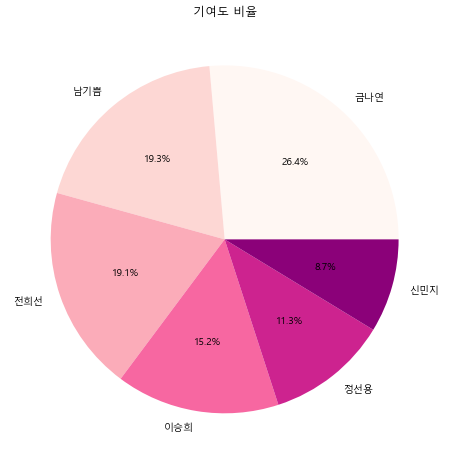

In [15]:
piechart_score()

# 프론트에 출력할 리스트 만들기

In [16]:
## 기여도 리스트
rank_name_list = list(feature_scaled.sort_values(by='score',ascending=False).index)
rank_ratio_list = list(feature_scaled.sort_values(by='score',ascending=False)['ratio'])
len_rank=len(rank_name_list)
rank_ratio_list

[26.4, 19.3, 19.1, 15.2, 11.3, 8.7]

In [17]:
# 프론트에 사용할 변수 생성
for i in range(0,len_rank):
    globals()['person{}'.format(i+1)] = rank_name_list[i]
    globals()['ratio{}'.format(i+1)] = rank_ratio_list[i]

# 추가 구현 ex)이모티콘왕

In [18]:
# 웃음왕
happy_name_list = list(feature.sort_values(by='happiness',ascending=False).index)
happy_ratio_list = list(round(feature.sort_values(by='happiness',ascending=False)['happiness']/sum(feature['happiness'])*100,1))
happy_rank_name = happy_name_list[0]
happy_rank_ratio = happy_ratio_list[0]
# 울음왕
sad_name_list = list(feature.sort_values(by='sadness',ascending=False).index)
sad_ratio_list = list(round(feature.sort_values(by='sadness',ascending=False)['sadness']/sum(feature['sadness'])*100,1))
sad_rank_name = sad_name_list[0]
sad_rank_ratio = sad_ratio_list[0]
# 물음표왕
ques_name_list = list(feature.sort_values(by='?',ascending=False).index)
ques_ratio_list = list(round(feature.sort_values(by='?',ascending=False)['?']/sum(feature['?'])*100,1))
ques_rank_name = ques_name_list[0]
ques_rank_ratio = ques_ratio_list[0]
# 느낌표왕
excm_name_list = list(feature.sort_values(by='!',ascending=False).index)
excm_ratio_list = list(round(feature.sort_values(by='!',ascending=False)['!']/sum(feature['!'])*100,1))
excm_rank_name = excm_name_list[0]
excm_rank_ratio = excm_ratio_list[0]
# 이모티콘왕
imo_name_list = list(feature.sort_values(by='emoticon',ascending=False).index)
imo_ratio_list = list(round(feature.sort_values(by='emoticon',ascending=False)['emoticon']/sum(feature['emoticon'])*100,1))
imo_rank_name = imo_name_list[0]
imo_rank_ratio = imo_ratio_list[0]